In [1]:
import scanpy as sc

In [2]:
sc.logging.print_header()

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-02-14 19:10:17.139852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 19:10:17.352110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 19:10:17.352131: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [3]:
adata = sc.read_h5ad('/lustre/groups/ml01/workspace/yuge.ji/covid-perturbation/data/2212_annot_patient_integrated.h5ad')
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 226459 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'leiden_coarse', 'leiden_fine', 'leiden_subset', 'celltype_fine', 'celltype_approx', 'ambient'
    var: 'used_for_scvi'
    uns: '_scvi', 'ambient_colors', 'cell_type_colors', 'celltype_approx_colors', 'celltype_coarse_colors', 'celltype_fine_colors', 'dendrogram_leiden_fine', 'hvg', 'infected_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_fine_colors', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs['patient'] = [p.replace('_', ' ').capitalize() for p in adata.obs.patient.values]

In [6]:
adata.obs['cell_type'] = [ct.capitalize() if 'unk' not in ct else ct for ct in adata.obs.cell_type.values]

In [7]:
adata.obs['treatment'] = adata.obs.treatment.replace({'IFNa (b_d)':'IFNa'})
adata.obs['treatment'] = [t.replace('_', ' + ') for t in adata.obs.treatment.values]

In [ ]:
adata.obs['infection'] = adata.obs['infected'].replace({'True':'Infected', 'False':'Uninfected'})

In [8]:
adata.write('2301_annot_patient_integrated_ambient_removed.h5ad')

Some additional adjustments.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [2]:
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')

In [3]:
adata = adata[adata.obs.cell_type != 'Hillock']

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:3

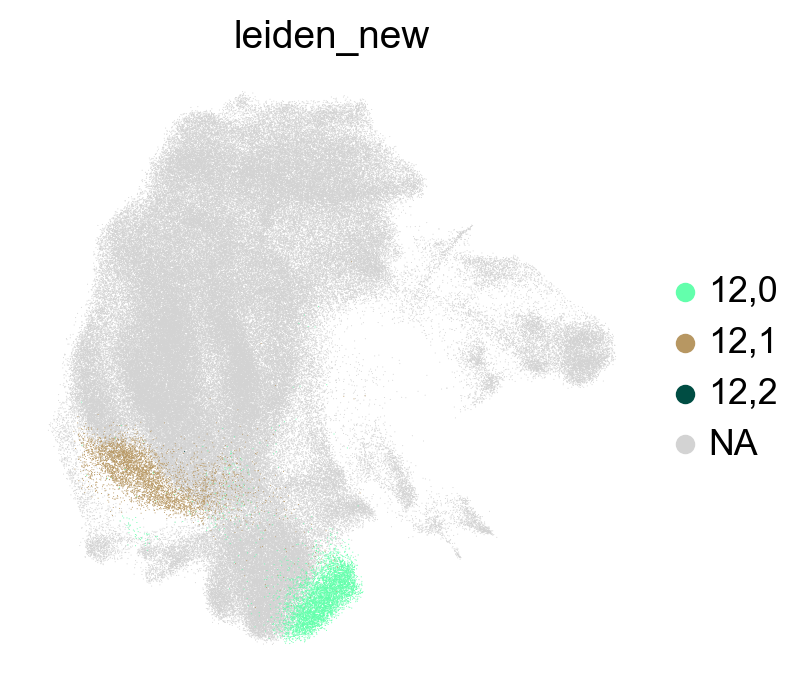

In [4]:
# split bad leiden cluster
sc.tl.leiden(adata, restrict_to=('leiden', ['12']), key_added='leiden_new', resolution=.2)
sc.pl.umap(adata, color='leiden_new', groups=['12,0', '12,1', '12,2'])
idx = adata.obs.leiden_new.isin(['12,0', '12,1', '12,2'])
adata.obs['leiden_new'] = adata.obs['leiden_new'].replace({
    '12,0': '12/basal',
    '12,1': '12/suprabasal',
    '12,2': '12/suprabasal'
})

adata.obs['celltype_fine'] = adata.obs.celltype_fine.astype(str)
adata.obs.loc[idx, ['celltype_fine']] = adata.obs['leiden_new'][idx]

In [5]:
adata.obs.celltype_fine = adata.obs.celltype_fine.replace({'9/basal':'9/suprabasal'})
adata.obs['cell_type'] = [s.split('/')[1] for s in adata.obs.celltype_fine.values]

In [6]:
adata.obs['cell_type'] = [ct.capitalize() if 'PNEC' not in ct else ct for ct in adata.obs.cell_type.values]

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


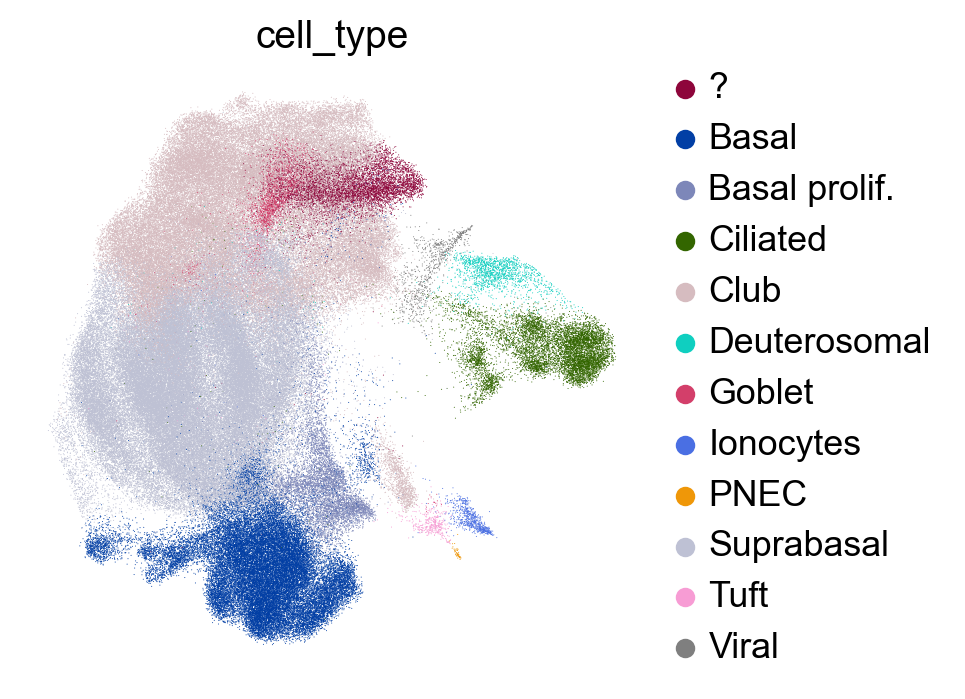

In [7]:
sc.pl.umap(adata, color='cell_type')

Adjust colors for better visibility.

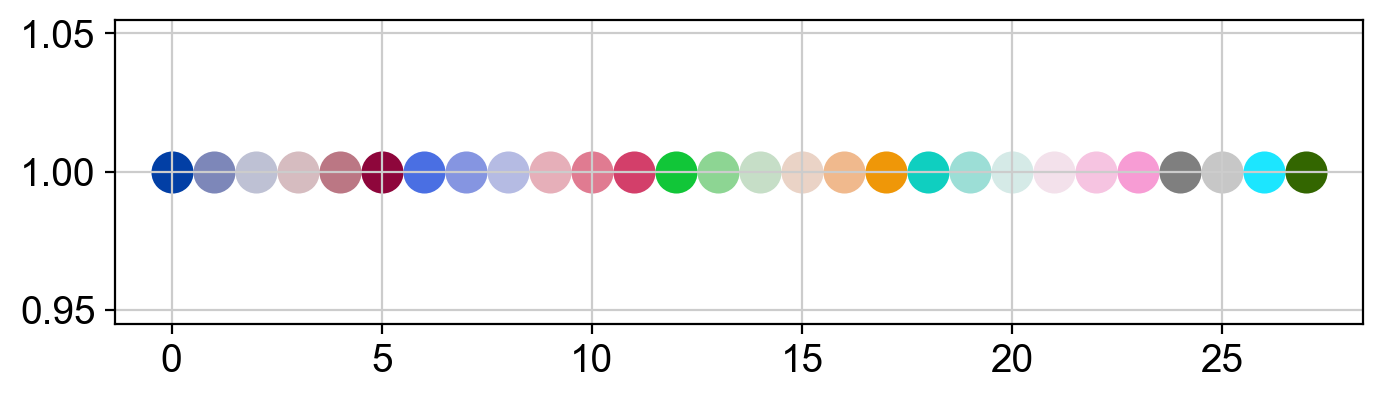

In [8]:
plt.figure(figsize=(8, 2))
for i in range(28):
    plt.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
plt.show()

In [9]:
adata.uns['cell_type_colors'] = list(np.array(sc.pl.palettes.zeileis_28)[[ #0, 1, 2, 3, 4, 5,
    5, # ?
    0, 1,  # basal
    27, # ciliated
    3, # club
    18, 11, 6, 17, # rare
    2, # suprabasal
    23, 24 # rare
]])

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


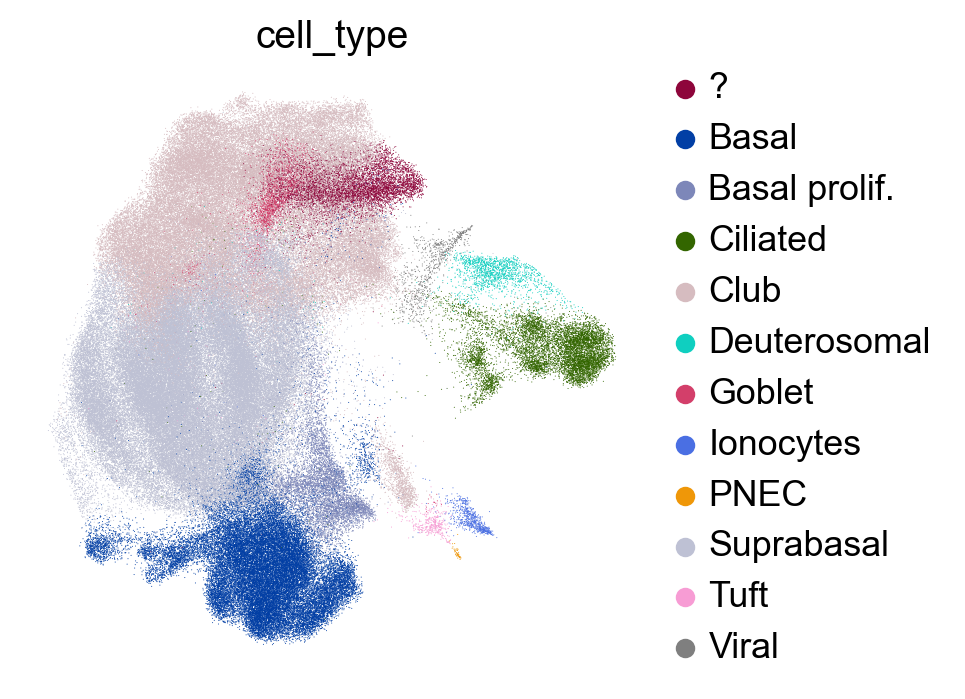

In [10]:
sc.pl.umap(adata, color='cell_type', palette=adata.uns['cell_type_colors'])

In [29]:
adata.write('2301_annot_patient_integrated_ambient_removed.h5ad')